# Jogo Organelas - Conhecendo as organelas de uma célula - EICA
  This file is part of program Organela
  Copyright © 2022 Carlo Oliveira carlo@nce.ufrj.br,
  Labase <http://labase.selfip.org/>; GPL <http://is.gd/3Udt>.
  SPDX-License-Identifier: (GPLv3-or-later AND LGPL-2.0-only) WITH bison-exception

## Análise dos dados da API de coleta para obtenção de estados EICA
Observa os dados numa série temporal para obtenção dos Estados EICA.

[!NOTE]
  codeauthor:: Carlo Oliveira [carlo at ufrj](mailto:carlo@ufrj.br)

## Changelog

<!--![version added](https://raw.githubusercontent.com/FortAwesome/Font-Awesome/6.x/svgs/solid/circle-plus.svg)  22.06-->
<img src="https://raw.githubusercontent.com/FortAwesome/Font-Awesome/6.x/svgs/solid/circle-plus.svg" width=16/>  22.06

* Extração do código EICA
* Características dos estados EICA
* Estudo das transições/palavras
* Estudo dos falantes por transição

<img src="https://raw.githubusercontent.com/FortAwesome/Font-Awesome/6.x/svgs/solid/circle-plus.svg" width=16/>  22.09

* Divisão do tempo em duas metades
* Estudo das transições por participante nas metades
* Estudo dos participantes por trasição nas metades


In [ ]:
import urllib.request
from json import loads
import pandas as pd
lisa_score_url = "https://raw.githubusercontent.com/kwarwp/lorinda/master/lisa/__score__.py"
f00 = "{'doc_id': 'a42ac145', 'carta': 'parte_1', 'casa': 'Fase0', 'move': 'local', 'ponto': 0, 'valor': 'local', '_level': 1, 'tempo': ".replace("'", '"')
try:
    with urllib.request.urlopen(lisa_score_url) as f, open("lisa_score.csv", "w") as score_csv:
        lisa_score = f.read().decode('utf-8').replace("'", '"').replace("Fase","Fase0").replace("Fase011","Fase11")
        lisa_score = f"[{lisa_score[:-2]}]"
        lisa_score = loads(lisa_score)
        headings = ['doc_id', 'carta', 'casa', 'move', 'ponto', 'valor', '_level', 'tempo']
        datan = {key: [] for key in headings}
        [datan[key].append(val) for line in lisa_score for key, val in line.items() if key in headings]
        df = pd.DataFrame(datan)
        df.sort_values(by=['doc_id','tempo',], inplace=True)
        df["movetime"] = df.groupby('doc_id').tempo.diff()
        df = df[df.groupby(['doc_id'])['movetime'].transform('sum') > 100000]
        df.tempo = pd.to_datetime(df.tempo)
        df.info()
except urllib.error.URLError as e:
    print(e.reason)
df

## Recorte dos jogadores usando o mesmo computador
O arquivo de dados registra uma única identificação para todos os jogadores que usaram o mesmo computador. Este código separa estes jogadores baseado em registro de início de jogo.
Calcula também a velocidade de reação e a aceleração desta reação pelos participantes.


In [ ]:
ddict = df.to_dict('records')
ALPHA = [a+b for a in "bcdfghjklmnpqrstvxz" for b in "01234"]
cuts = [ind for ind, dc in enumerate(ddict) if (dc['casa'] == "Fase01") and (dc["carta"] == "parte_0")]
cuts = zip(cuts, cuts[1:]+[len(df)])
cuts = list(cuts)
dcut = [{k: v if k != "doc_id" else ALPHA[ind] for k,v in dc.items()}
        for ind, (st,ed) in enumerate(cuts) for dc in ddict[st:ed]
        if ((ed-st)>10) and ind <200 and ALPHA[ind] not in "g1 k3 s1"]
dcuts = [[{k: v if k != "doc_id" else ALPHA[ind] for k, v in dc.items()} for dc in ddict[st:ed]]
         for ind, (st,ed) in enumerate(cuts) if ((ed-st)>10)]# and ind not in (6, 9, 23, 17, 19) and ind <20]
df = pd.DataFrame(dcut)
df.loc[(df["casa"] == "Fase01")&(df["carta"] == "parte_0"), "movetime"] = 111.1
df["movedelta"] = df.groupby('doc_id')['movetime'].apply(lambda x: x - x.shift(1))
df["movejump"] = df.groupby('doc_id')['movedelta'].apply(lambda x: x - x.shift(1))
df["time"] = df.groupby(['doc_id'])['movetime'].cumsum() #.apply(lambda x: x.shift()+x)
df

## Preparação para extrair séries temporais
As séries serão ajustadas para interpolação.


In [ ]:
ds = df.loc[:, ['doc_id', 'time', 'movejump']]
ds['time'] = pd.to_numeric(df['time'], errors='coerce').fillna(0).astype(int)
ds.index = ds['time'].div(1000).astype(int)
del ds['time']
dfs = {did:x.iloc[:64,:] for did, x in ds.groupby('doc_id') if x.index[-1] > 400}


## Discriminador dos estados EICA
A partir da segunda derivada das ações do participante, o wavelet separa as transições essenciais. Derivando os wavelets podemos determinar os coeficientes angulares característicos dos estados EICA

In [ ]:
def discriminate_eica_states(data_frame):
    sencond_deriv = data_frame['movejump'].values
    tim = data_frame.index.values
    from scipy.interpolate import interp1d
    import numpy as npy
    from math import log, isnan
    linear_time_space_ = npy.linspace(tim[0], tim[-1], (tim[-1] - tim[0]))
    interpolating_function_ = interp1d(tim, sencond_deriv, kind='slinear')
    y_inter= interpolating_function_(linear_time_space_)
    import pywt
    wlet = pywt.Wavelet('db3')
    _,y_wav = pywt.dwt(y_inter, wlet) #'bior1.3')
    y_wav = [0 if isnan(_y) else log(_y) if _y > 0 else -log(abs(_y)+0.05) for _y in y_wav]
    y_wav = [y1 - y0 for y0, y1 in zip(y_wav, y_wav[1:]+[0])]
    y_wav = [int((_y+40)//25) for _y in y_wav]
    # y_wav_size = len(y_wav)
    eica = [(tempo, a+b*3+b*9) for tempo,a,b,c in zip(linear_time_space_, y_wav, y_wav[+1:]+[0], y_wav[+2:]+[0,0])][::3]
    # eica_states = list(set(eica))
    return eica
# all_states = [dict(aut=aut, st=st) for aut, df_ in enumerate(dfs) for st in discriminate_eica_states(df_)]
all_states = [dict(aut=aut, st=st, tempo=tempo) for aut, df_ in dfs.items() for tempo,st in discriminate_eica_states(df_)]
df_states = pd.DataFrame(all_states)
# df_states["st"] = df_states["st"].map({k: f"est{v}" for v, k in enumerate([13,24, 1, 14,25,2,12])})
df_states["st"] = df_states["st"].map({k: f"est{v}" for v, k in enumerate([13,24, 14, 1,25,2,12])})

df_states

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


## Distribuição estatística das incidências dos estados EICA
Os estados EICA tem um perfil de incidência caractístico, desde os mais frequentes até os menos frequentes.

In [ ]:
dst_cnt = df_states.groupby(["aut"])["st"].value_counts()
dst_dct = [dict(aut=aut, st=st, stc=stc) for (aut, st), stc in dst_cnt.to_dict().items() if st not in (0, 37, 36, 26,3)]
df_st_cnt = pd.DataFrame(dst_dct)
# df_states['st_cnt'] = df_states["st"].map(dst_dct)
# sns.violinplot(x="st", y="stc", data=df_st_cnt, order=[13,24, 1, 14,25,2,12]) # , 36, 26, 3])
sns.violinplot(x="st", y="stc", data=df_st_cnt, order=[f"est{v}" for v in range(7)]).set(
    title="Estatística da frequência de ocorrência", xlabel="Estados EICA", ylabel="Frequência de repetição")

plt.gcf().set_size_inches(20, 10)

## Intervalo de ocorrência entre cada estado
Avalia o quanto demora para um estado reaparecer na série temporal.

In [ ]:
df_states["interval"] = df_states.groupby(["aut", "st"]).tempo.diff()
# df_states
sns.violinplot(x="st", y="interval", data=df_states, order=[f"est{v}" for v in range(7)]).set(
    ylim=(-30,100), title="Estatística do intervalo de ocorrência", xlabel="Estados EICA", ylabel="Intervalo de repetição")
plt.gcf().set_size_inches(20, 10)

## Perfil cognitivo simplificado dos participantes
A distribuição das incidências dos estados EICA característica de cada participante

In [ ]:
df_st_cnt["stsum"] = df_st_cnt.groupby("aut")["st"].transform('count')#.sum()
d_sst = df_st_cnt.sort_values(by="stsum", ascending=False)
d_sst = d_sst.drop(["stsum"], axis=1)
sns.violinplot(x="aut", y="stc", data=d_sst).set(
    ylim=(-30,60), title="Estatística dos estados por autor", xlabel="Participantes", ylabel="Estatísticas da distribuição dos estados") # , 36, 26, 3])
plt.gcf().set_size_inches(20, 10)


## Contagem de estados por autor
Observando os estados e suas incidências para cada autor.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
d_sort_states = df_states.sort_values(by="st")
sns.histplot(x=d_sort_states.st, data=d_sort_states, hue=d_sort_states.aut, bins=28*3, multiple="stack").set(
    title="Contagem de estados por autor", xlabel="Estados Eicas", ylabel="Contagem dos estados")

plt.gcf().set_size_inches(20, 10)
# print((all_states))

## Contagem acumulada de estados por participante
Apresenta numa pilha cumulativa a contagem de incidências de cada estado por participante.

In [ ]:
df_states["stsum"] = df_states.groupby("aut")["tempo"].transform('count')#.sum()
d_sst = df_states.sort_values(by="stsum", ascending=False)
d_sst = d_sst.drop(["stsum"], axis=1)

sns.histplot(x=d_sst.aut, data=d_sst, multiple="stack", hue=d_sst.st).set(
    title="Contagem de estados por autor", xlabel="Participantes", ylabel="Contagem dos estados")
plt.legend(title="Es. EICA", loc="upper right", labels=[f"est{s}" for s in range(6,-1,-1)])
plt.gcf().set_size_inches(20, 10)

## Contagem acumulada de palavras de duas letras por participante
Apresenta numa pilha cumulativa a contagem de incidências de cada sequência de dois estado por participante.

In [ ]:
d_sst["wd3"] = d_sst.groupby("aut")["st"].transform(lambda st: st+st.shift(1)) #+st.shift(2))
d_sst["wd3cnt"] = d_sst.groupby(["aut", 'wd3'])["wd3"].transform("count")
d_sst = d_sst.sort_values(by="wd3cnt", ascending=False)
d_sst_ct = d_sst[d_sst["wd3cnt"] >3]
# d_sst = d_sst.drop(["stsum"], axis=1)

sns.histplot(x=d_sst_ct.wd3, data=d_sst_ct, multiple="stack", hue=d_sst_ct.aut).set(ylim=(0,30),
    title="Contagem de autor por palavras", xlabel="Palavras", ylabel="Contagem dos autores")
# plt.legend(title="Es. EICA", loc="upper right") #, labels=[f"est{s}" for s in range(7)])
plt.xticks(rotation=45)
plt.gcf().set_size_inches(20, 10)
d_sst

## Contagem falantes por língua e línguas por falantes
Agrega as línguas de cada falante e os fallantes de cada língua.

In [ ]:
a = d_sst_ct.groupby('aut').agg({'wd3': lambda x: tuple(sorted(set(x))), 'wd3cnt':'count'})
d_sst_dial = a.explode('wd3').reset_index()
s = d_sst_ct.groupby('wd3').agg({'aut': lambda x: tuple(sorted(set(x))), 'wd3cnt':'count'})
d_sst_spk = s.explode('aut').reset_index()
d_sst_dial["dialspk"] = d_sst_dial.groupby('aut')['wd3cnt'].transform('count')
d_sst_dial["spkdial"] = d_sst_dial.groupby('wd3')['wd3cnt'].transform('count')
d_sst_spk["spkdial"] = d_sst_spk.groupby('wd3')['wd3cnt'].transform('count')
d_sst_spk["dialspk"] = d_sst_spk.groupby('aut')['wd3cnt'].transform('count')
d_sst_spk = d_sst_spk[d_sst_spk["dialspk"]>5]
d_sst_dial = d_sst_dial[d_sst_dial["dialspk"]>5]
d_sst_spk = d_sst_spk[d_sst_spk["spkdial"]>2]
d_sst_dial = d_sst_dial[d_sst_dial["spkdial"]>2]

# print(a.explode('wd3'))
print(d_sst_spk.head(15))
d_sst_dial.head(5)

## Plotagem de falantes por língua.
Agrega os fallantes de cada língua.

In [ ]:
d_sst_dial = d_sst_dial.sort_values(by="spkdial", ascending=False)

sns.histplot(x=d_sst_dial.wd3, data=d_sst_dial, multiple="stack", hue=d_sst_dial.aut).set(
    ylim=(0,22),title="Listagem de Falantes por transição entre estados", xlabel="Nomes das Transições", ylabel="Listagem de Falantes")
#
plt.xticks(rotation=45)
plt.gcf().set_size_inches(20, 10)
d_sst_dial

## Contagem de línguas por falantes
Agrega as línguas de cada falante.

In [ ]:
d_sst_spk = d_sst_spk.sort_values(by="dialspk", ascending=False)
d_sst_spk = d_sst_spk.rename(columns = {"wd3": "transições", "dialspk": "incidências", "spkdial": "falantes"})#, "aut": "participantes"})
sns.histplot(x=d_sst_spk.aut, data=d_sst_spk, multiple="stack", hue="transições").set(
    xlim=(-2,24),ylim=(0,28),title="Listagem de Transições entre estados", xlabel="Identificador dos Falantes", ylabel="Listagem de Transições")
plt.xticks(rotation=45)
plt.gcf().set_size_inches(20, 10)

## Correlação entre transições e falantes dos dialetos

In [ ]:
# pal=sns.color_palette("Spectral",21)BrBGPiYGx_jitter=500,y_jitter=300,RdYlBu
pal=sns.color_palette("cubehelix",21)
d_sst_spk = d_sst_spk.rename(columns = {"aut": "participantes"})

#sns.scatterplot(data=d_sst_spk,x="wd3",y="spkdial",hue="aut", size="dialspk", sizes=(100,1000)).set(
sns.scatterplot(palette=pal, alpha=0.95, data=d_sst_spk,x="transições",y="incidências",hue="participantes", size="falantes", sizes=(300,2000)).set(
# sns.scatterplot(data=d_sst_spk,x="spkdial",y="dialspk",hue="aut", sizes=(1000,1000)).set(
    xlim=(-2, 40), ylim=(0, 26), title="Correlação entre Transições e Falantes", xlabel="Nomes das Transições", ylabel="Incidência de Falantes")
plt.xticks(rotation=45)
plt.gcf().set_size_inches(20, 10)

# Recorte dos Eventos em dois Segmentos
Os dados dos eventos é recortado em dois segmentos. O primeiro terá os eventos iniciais e o segundo os finais. O propósito é avaliar a evolução microgenética da cognição. Segue uma comparação na contagem de estados para avaliar a evolução

In [ ]:
df_front = df_states[df_states['tempo'] <= 200]
df_back = df_states[(200 < df_states['tempo']) & ( df_states['tempo'] < 400)]
df_back

## Calcula a metade frontal

In [ ]:
df_front["stsumf"] = df_front.groupby("aut")["tempo"].transform('count')#.sum()
d_sstf = df_front # df_front.sort_values(by="stsumf", ascending=False)
d_sstf = d_sstf.drop(["stsumf"], axis=1)

sns.histplot(x=d_sstf.aut, data=d_sstf, multiple="stack", hue=d_sstf.st).set(
    title="Contagem de estados por autor metade inicial", xlabel="Participantes", ylabel="Contagem dos estados")
plt.legend(title="Es. EICA", loc="upper right", labels=[f"est{s}" for s in range(6, -1, -1)])
plt.gcf().set_size_inches(20, 10)

## Calcula a metade final

In [ ]:
df_back["stsumb"] = df_back.groupby("aut")["tempo"].transform('count')#.sum()
d_sstb = df_back # df_back.sort_values(by="stsumb", ascending=False)
d_sstb = d_sstb.drop(["stsumb"], axis=1)

sns.histplot(x=d_sstb.aut, data=d_sstb, multiple="stack", hue=d_sstb.st).set(
    title="Contagem de estados por autor metade final", xlabel="Participantes", ylabel="Contagem dos estados")
plt.legend(title="Es. EICA", loc="upper right", labels=[f"est{s}" for s in range(6, -1, -1)])
plt.gcf().set_size_inches(20, 10)

## Contagem de palavras de duas letras

Concatenação de um estado com o estado seguinte para observar as sílabas do vocabulário mental

In [ ]:
df_back["wd3"] = df_back.groupby("aut")["st"].transform(lambda st: st+st.shift(1)) #+st.shift(2))
df_back["wd3cnt"] = df_back.groupby(["aut", 'wd3'])["wd3"].transform("count")
df_back = df_back[df_back["wd3cnt"] >2]

df_front["wd3"] = df_front.groupby("aut")["st"].transform(lambda st: st+st.shift(1)) #+st.shift(2))
df_front["wd3cnt"] = df_front.groupby(["aut", 'wd3'])["wd3"].transform("count")
df_front = df_front[df_front["wd3cnt"] >2]
df_front

## Contagem das Transições Expressas por Participante
Conta quantas transições cada participante expressou em cada metade do jogo


In [ ]:
s = df_front.groupby('wd3').agg({'aut': lambda x: tuple(sorted(set(x))), 'wd3cnt':'count'})
df_vocabulary = s.explode('aut').reset_index()
df_vocabulary["speak_token"] = df_vocabulary.groupby('aut')['wd3cnt'].transform('count')
df_vocabulary = df_vocabulary[df_vocabulary["speak_token"]>2]
df_vocabulary.head(5)
s = df_back.groupby('wd3').agg({'aut': lambda x: tuple(sorted(set(x))), 'wd3cnt':'count'})
df_end_vocabulary = s.explode('aut').reset_index()
df_end_vocabulary["speak_token"] = df_end_vocabulary.groupby('aut')['wd3cnt'].transform('count')
df_end_vocabulary = df_end_vocabulary[df_end_vocabulary["speak_token"]>2]
df_end_vocabulary.head(5)

## Plotagem do Vocabulário Inicial dos Participantes
Conta quantas sílabas os participantes falaram na porção inicial do jogo

In [ ]:
df_front = df_front.rename(columns = {"wd3": "transições"})#, "aut": "participantes"})
sns.histplot(x=df_front.aut, data=df_front, stat="count", multiple="stack", hue="transições", kde=False,).set(
    xlim=(-2,32),ylim=(0, 55),title="Contagem de Transições Entre Estados no Primeiro Segmento", xlabel="Identificador dos Falantes", ylabel="Contagem de Transições")
plt.xticks(rotation=45)
plt.gcf().set_size_inches(20, 10)

## Plotagem do Vocabulário Final dos Participantes
Conta quantas sílabas os participantes falaram na porção final do jogo

In [ ]:
df_back = df_back.rename(columns = {"wd3": "transições"})#, "aut": "participantes"})
sns.histplot(x=df_back.aut, data=df_back, stat="count", multiple="stack", hue="transições", kde=False,).set(
    xlim=(-2,28),ylim=(0, 50),title="Contagem de Transições Entre Estados no Segundo Segmento", xlabel="Identificador dos Falantes", ylabel="Contagem de Transições")
plt.xticks(rotation=45)
plt.gcf().set_size_inches(20, 10)

## Plotagem do Vocabulário Final por Transições
Conta quantos participantes expressaram uma dada trasição na porção final do jogo


In [ ]:
df_back_sort = df_back.sort_values(by="transições")

sns.histplot(x=df_back_sort.transições, data=df_back_sort, stat="count", multiple="stack", hue="aut", kde=False,).set(
    xlim=(-2,48),ylim=(0, 50),title="Contagem de Autores Por Transição no Segundo Segmento", xlabel="Identificador das Transições", ylabel="Contagem de Autores")
plt.xticks(rotation=45)
plt.gcf().set_size_inches(20, 10)

## Plotagem do Vocabulário Inicial por Transições
Conta quantos participantes expressaram uma dada trasição na porção inicial do jogo


In [ ]:
df_front_sort = df_front.sort_values(by="transições")

sns.histplot(x=df_front_sort.transições, data=df_front_sort, stat="count", multiple="stack", hue="aut", kde=False,).set(
    xlim=(-2,48),ylim=(0, 50),title="Contagem de Autores Por Transição no Segundo Segmento", xlabel="Identificador das Transições", ylabel="Contagem de Autores")
plt.xticks(rotation=45)
plt.gcf().set_size_inches(20, 10)

In [ ]:
df_front = df_states[df_states['tempo'] <= 200]
df_back = df_states[(200 < df_states['tempo']) & ( df_states['tempo'] < 400)]
df_back

## Calcula a metade frontal

In [ ]:
df_front["stsumf"] = df_front.groupby("aut")["tempo"].transform('count')#.sum()
d_sstf = df_front # df_front.sort_values(by="stsumf", ascending=False)
d_sstf = d_sstf.drop(["stsumf"], axis=1)

sns.histplot(x=d_sstf.aut, data=d_sstf, multiple="stack", hue=d_sstf.st).set(
    title="Contagem de estados por autor metade inicial", xlabel="Participantes", ylabel="Contagem dos estados")
plt.legend(title="Es. EICA", loc="upper right", labels=[f"est{s}" for s in range(6, -1, -1)])
plt.gcf().set_size_inches(20, 10)

## Calcula a metade final

In [ ]:
df_back["stsumb"] = df_back.groupby("aut")["tempo"].transform('count')#.sum()
d_sstb = df_back # df_back.sort_values(by="stsumb", ascending=False)
d_sstb = d_sstb.drop(["stsumb"], axis=1)

sns.histplot(x=d_sstb.aut, data=d_sstb, multiple="stack", hue=d_sstb.st).set(
    title="Contagem de estados por autor metade final", xlabel="Participantes", ylabel="Contagem dos estados")
plt.legend(title="Es. EICA", loc="upper right", labels=[f"est{s}" for s in range(6, -1, -1)])
plt.gcf().set_size_inches(20, 10)

## Contagem de palavras de duas letras

Concatenação de um estado com o estado seguinte para observar as sílabas do vocabulário mental

In [ ]:
df_back["wd3"] = df_back.groupby("aut")["st"].transform(lambda st: st+st.shift(1)) #+st.shift(2))
df_back["wd3cnt"] = df_back.groupby(["aut", 'wd3'])["wd3"].transform("count")
df_back = df_back[df_back["wd3cnt"] >2]

df_front["wd3"] = df_front.groupby("aut")["st"].transform(lambda st: st+st.shift(1)) #+st.shift(2))
df_front["wd3cnt"] = df_front.groupby(["aut", 'wd3'])["wd3"].transform("count")
df_front = df_front[df_front["wd3cnt"] >2]
df_front

## Contagem das Transições Expressas por Participante
Conta quantas transições cada participante expressou em cada metade do jogo


In [ ]:
s = df_front.groupby('wd3').agg({'aut': lambda x: tuple(sorted(set(x))), 'wd3cnt':'count'})
df_vocabulary = s.explode('aut').reset_index()
df_vocabulary["speak_token"] = df_vocabulary.groupby('aut')['wd3cnt'].transform('count')
df_vocabulary = df_vocabulary[df_vocabulary["speak_token"]>2]
df_vocabulary.head(5)
s = df_back.groupby('wd3').agg({'aut': lambda x: tuple(sorted(set(x))), 'wd3cnt':'count'})
df_end_vocabulary = s.explode('aut').reset_index()
df_end_vocabulary["speak_token"] = df_end_vocabulary.groupby('aut')['wd3cnt'].transform('count')
df_end_vocabulary = df_end_vocabulary[df_end_vocabulary["speak_token"]>2]
df_end_vocabulary.head(5)

## Plotagem do Vocabulário Inicial dos Participantes
Conta quantas sílabas os participantes falaram na porção inicial do jogo

In [ ]:
df_front = df_front.rename(columns = {"wd3": "transições"})#, "aut": "participantes"})
sns.histplot(x=df_front.aut, data=df_front, stat="count", multiple="stack", hue="transições", kde=False,).set(
    xlim=(-2,32),ylim=(0, 55),title="Contagem de Transições Entre Estados no Primeiro Segmento", xlabel="Identificador dos Falantes", ylabel="Contagem de Transições")
plt.xticks(rotation=45)
plt.gcf().set_size_inches(20, 10)

## Plotagem do Vocabulário Final dos Participantes
Conta quantas sílabas os participantes falaram na porção final do jogo

In [ ]:
df_back = df_back.rename(columns = {"wd3": "transições"})#, "aut": "participantes"})
sns.histplot(x=df_back.aut, data=df_back, stat="count", multiple="stack", hue="transições", kde=False,).set(
    xlim=(-2,28),ylim=(0, 50),title="Contagem de Transições Entre Estados no Segundo Segmento", xlabel="Identificador dos Falantes", ylabel="Contagem de Transições")
plt.xticks(rotation=45)
plt.gcf().set_size_inches(20, 10)

## Plotagem do Vocabulário Final por Transições
Conta quantos participantes expressaram uma dada trasição na porção final do jogo


In [ ]:
df_back_sort = df_back.sort_values(by="transições")

sns.histplot(x=df_back_sort.transições, data=df_back_sort, stat="count", multiple="stack", hue="aut", kde=False,).set(
    xlim=(-2,48),ylim=(0, 50),title="Contagem de Autores Por Transição no Segundo Segmento", xlabel="Identificador das Transições", ylabel="Contagem de Autores")
plt.xticks(rotation=45)
plt.gcf().set_size_inches(20, 10)

## Plotagem do Vocabulário Inicial por Transições
Conta quantos participantes expressaram uma dada trasição na porção inicial do jogo


In [ ]:
df_front_sort = df_front.sort_values(by="transições")

sns.histplot(x=df_front_sort.transições, data=df_front_sort, stat="count", multiple="stack", hue="aut", kde=False,).set(
    xlim=(-2,48),ylim=(0, 50),title="Contagem de Autores Por Transição no Segundo Segmento", xlabel="Identificador das Transições", ylabel="Contagem de Autores")
plt.xticks(rotation=45)
plt.gcf().set_size_inches(20, 10)

## Calcula a metade frontal

In [ ]:
df_front["stsumf"] = df_front.groupby("aut")["tempo"].transform('count')#.sum()
d_sstf = df_front # df_front.sort_values(by="stsumf", ascending=False)
d_sstf = d_sstf.drop(["stsumf"], axis=1)

sns.histplot(x=d_sstf.aut, data=d_sstf, multiple="stack", hue=d_sstf.st).set(
    title="Contagem de estados por autor metade inicial", xlabel="Participantes", ylabel="Contagem dos estados")
plt.legend(title="Es. EICA", loc="upper right", labels=[f"est{s}" for s in range(6, -1, -1)])
plt.gcf().set_size_inches(20, 10)

## Calcula a metade final

In [ ]:
df_back["stsumb"] = df_back.groupby("aut")["tempo"].transform('count')#.sum()
d_sstb = df_back # df_back.sort_values(by="stsumb", ascending=False)
d_sstb = d_sstb.drop(["stsumb"], axis=1)

sns.histplot(x=d_sstb.aut, data=d_sstb, multiple="stack", hue=d_sstb.st).set(
    title="Contagem de estados por autor metade final", xlabel="Participantes", ylabel="Contagem dos estados")
plt.legend(title="Es. EICA", loc="upper right", labels=[f"est{s}" for s in range(6, -1, -1)])
plt.gcf().set_size_inches(20, 10)

## Contagem de palavras de duas letras

Concatenação de um estado com o estado seguinte para observar as sílabas do vocabulário mental

In [ ]:
df_back["wd3"] = df_back.groupby("aut")["st"].transform(lambda st: st+st.shift(1)) #+st.shift(2))
df_back["wd3cnt"] = df_back.groupby(["aut", 'wd3'])["wd3"].transform("count")
df_back = df_back[df_back["wd3cnt"] >2]

df_front["wd3"] = df_front.groupby("aut")["st"].transform(lambda st: st+st.shift(1)) #+st.shift(2))
df_front["wd3cnt"] = df_front.groupby(["aut", 'wd3'])["wd3"].transform("count")
df_front = df_front[df_front["wd3cnt"] >2]
df_front

## Contagem das Transições Expressas por Participante
Conta quantas transições cada participante expressou em cada metade do jogo


In [ ]:
s = df_front.groupby('wd3').agg({'aut': lambda x: tuple(sorted(set(x))), 'wd3cnt':'count'})
df_vocabulary = s.explode('aut').reset_index()
df_vocabulary["speak_token"] = df_vocabulary.groupby('aut')['wd3cnt'].transform('count')
df_vocabulary = df_vocabulary[df_vocabulary["speak_token"]>2]
df_vocabulary.head(5)
s = df_back.groupby('wd3').agg({'aut': lambda x: tuple(sorted(set(x))), 'wd3cnt':'count'})
df_end_vocabulary = s.explode('aut').reset_index()
df_end_vocabulary["speak_token"] = df_end_vocabulary.groupby('aut')['wd3cnt'].transform('count')
df_end_vocabulary = df_end_vocabulary[df_end_vocabulary["speak_token"]>2]
df_end_vocabulary.head(5)

## Plotagem do Vocabulário Inicial dos Participantes
Conta quantas sílabas os participantes falaram na porção inicial do jogo

In [ ]:
df_front = df_front.rename(columns = {"wd3": "transições"})#, "aut": "participantes"})
sns.histplot(x=df_front.aut, data=df_front, stat="count", multiple="stack", hue="transições", kde=False,).set(
    xlim=(-2,32),ylim=(0, 55),title="Contagem de Transições Entre Estados no Primeiro Segmento", xlabel="Identificador dos Falantes", ylabel="Contagem de Transições")
plt.xticks(rotation=45)
plt.gcf().set_size_inches(20, 10)

## Plotagem do Vocabulário Final dos Participantes
Conta quantas sílabas os participantes falaram na porção final do jogo

In [ ]:
df_back = df_back.rename(columns = {"wd3": "transições"})#, "aut": "participantes"})
sns.histplot(x=df_back.aut, data=df_back, stat="count", multiple="stack", hue="transições", kde=False,).set(
    xlim=(-2,28),ylim=(0, 50),title="Contagem de Transições Entre Estados no Segundo Segmento", xlabel="Identificador dos Falantes", ylabel="Contagem de Transições")
plt.xticks(rotation=45)
plt.gcf().set_size_inches(20, 10)

## Plotagem do Vocabulário Final por Transições
Conta quantos participantes expressaram uma dada trasição na porção final do jogo


In [ ]:
df_back_sort = df_back.sort_values(by="transições")

sns.histplot(x=df_back_sort.transições, data=df_back_sort, stat="count", multiple="stack", hue="aut", kde=False,).set(
    xlim=(-2,48),ylim=(0, 50),title="Contagem de Autores Por Transição no Segundo Segmento", xlabel="Identificador das Transições", ylabel="Contagem de Autores")
plt.xticks(rotation=45)
plt.gcf().set_size_inches(20, 10)

## Plotagem do Vocabulário Inicial por Transições
Conta quantos participantes expressaram uma dada trasição na porção inicial do jogo


In [ ]:
df_front_sort = df_front.sort_values(by="transições")

sns.histplot(x=df_front_sort.transições, data=df_front_sort, stat="count", multiple="stack", hue="aut", kde=False,).set(
    xlim=(-2,48),ylim=(0, 50),title="Contagem de Autores Por Transição no Segundo Segmento", xlabel="Identificador das Transições", ylabel="Contagem de Autores")
plt.xticks(rotation=45)
plt.gcf().set_size_inches(20, 10)

In [ ]:
df_back["wd3"] = df_back.groupby("aut")["st"].transform(lambda st: st+st.shift(1)) #+st.shift(2))
df_back["wd3cnt"] = df_back.groupby(["aut", 'wd3'])["wd3"].transform("count")
df_back = df_back[df_back["wd3cnt"] >2]

df_front["wd3"] = df_front.groupby("aut")["st"].transform(lambda st: st+st.shift(1)) #+st.shift(2))
df_front["wd3cnt"] = df_front.groupby(["aut", 'wd3'])["wd3"].transform("count")
df_front = df_front[df_front["wd3cnt"] >2]
df_front

## Contagem das Transições Expressas por Participante
Conta quantas transições cada participante expressou em cada metade do jogo


In [ ]:
s = df_front.groupby('wd3').agg({'aut': lambda x: tuple(sorted(set(x))), 'wd3cnt':'count'})
df_vocabulary = s.explode('aut').reset_index()
df_vocabulary["speak_token"] = df_vocabulary.groupby('aut')['wd3cnt'].transform('count')
df_vocabulary = df_vocabulary[df_vocabulary["speak_token"]>2]
df_vocabulary.head(5)
s = df_back.groupby('wd3').agg({'aut': lambda x: tuple(sorted(set(x))), 'wd3cnt':'count'})
df_end_vocabulary = s.explode('aut').reset_index()
df_end_vocabulary["speak_token"] = df_end_vocabulary.groupby('aut')['wd3cnt'].transform('count')
df_end_vocabulary = df_end_vocabulary[df_end_vocabulary["speak_token"]>2]
df_end_vocabulary.head(5)

## Plotagem do Vocabulário Inicial dos Participantes
Conta quantas sílabas os participantes falaram na porção inicial do jogo

In [ ]:
df_front = df_front.rename(columns = {"wd3": "transições"})#, "aut": "participantes"})
sns.histplot(x=df_front.aut, data=df_front, stat="count", multiple="stack", hue="transições", kde=False,).set(
    xlim=(-2,32),ylim=(0, 55),title="Contagem de Transições Entre Estados no Primeiro Segmento", xlabel="Identificador dos Falantes", ylabel="Contagem de Transições")
plt.xticks(rotation=45)
plt.gcf().set_size_inches(20, 10)

## Plotagem do Vocabulário Final dos Participantes
Conta quantas sílabas os participantes falaram na porção final do jogo

In [ ]:
df_back = df_back.rename(columns = {"wd3": "transições"})#, "aut": "participantes"})
sns.histplot(x=df_back.aut, data=df_back, stat="count", multiple="stack", hue="transições", kde=False,).set(
    xlim=(-2,28),ylim=(0, 50),title="Contagem de Transições Entre Estados no Segundo Segmento", xlabel="Identificador dos Falantes", ylabel="Contagem de Transições")
plt.xticks(rotation=45)
plt.gcf().set_size_inches(20, 10)

## Plotagem do Vocabulário Final por Transições
Conta quantos participantes expressaram uma dada trasição na porção final do jogo


In [ ]:
df_back_sort = df_back.sort_values(by="transições")

sns.histplot(x=df_back_sort.transições, data=df_back_sort, stat="count", multiple="stack", hue="aut", kde=False,).set(
    xlim=(-2,48),ylim=(0, 50),title="Contagem de Autores Por Transição no Segundo Segmento", xlabel="Identificador das Transições", ylabel="Contagem de Autores")
plt.xticks(rotation=45)
plt.gcf().set_size_inches(20, 10)

## Plotagem do Vocabulário Inicial por Transições
Conta quantos participantes expressaram uma dada trasição na porção inicial do jogo


In [ ]:
df_front_sort = df_front.sort_values(by="transições")

sns.histplot(x=df_front_sort.transições, data=df_front_sort, stat="count", multiple="stack", hue="aut", kde=False,).set(
    xlim=(-2,48),ylim=(0, 50),title="Contagem de Autores Por Transição no Segundo Segmento", xlabel="Identificador das Transições", ylabel="Contagem de Autores")
plt.xticks(rotation=45)
plt.gcf().set_size_inches(20, 10)

In [ ]:
df_front = df_states[df_states['tempo'] <= 200]
df_back = df_states[(200 < df_states['tempo']) & ( df_states['tempo'] < 400)]
df_back

## Calcula a metade frontal

In [ ]:
df_front["stsumf"] = df_front.groupby("aut")["tempo"].transform('count')#.sum()
d_sstf = df_front # df_front.sort_values(by="stsumf", ascending=False)
d_sstf = d_sstf.drop(["stsumf"], axis=1)

sns.histplot(x=d_sstf.aut, data=d_sstf, multiple="stack", hue=d_sstf.st).set(
    title="Contagem de estados por autor metade inicial", xlabel="Participantes", ylabel="Contagem dos estados")
plt.legend(title="Es. EICA", loc="upper right", labels=[f"est{s}" for s in range(6, -1, -1)])
plt.gcf().set_size_inches(20, 10)

## Calcula a metade final

In [ ]:
df_back["stsumb"] = df_back.groupby("aut")["tempo"].transform('count')#.sum()
d_sstb = df_back # df_back.sort_values(by="stsumb", ascending=False)
d_sstb = d_sstb.drop(["stsumb"], axis=1)

sns.histplot(x=d_sstb.aut, data=d_sstb, multiple="stack", hue=d_sstb.st).set(
    title="Contagem de estados por autor metade final", xlabel="Participantes", ylabel="Contagem dos estados")
plt.legend(title="Es. EICA", loc="upper right", labels=[f"est{s}" for s in range(6, -1, -1)])
plt.gcf().set_size_inches(20, 10)

## Contagem de palavras de duas letras

Concatenação de um estado com o estado seguinte para observar as sílabas do vocabulário mental

In [ ]:
df_back["wd3"] = df_back.groupby("aut")["st"].transform(lambda st: st+st.shift(1)) #+st.shift(2))
df_back["wd3cnt"] = df_back.groupby(["aut", 'wd3'])["wd3"].transform("count")
df_back = df_back[df_back["wd3cnt"] >2]

df_front["wd3"] = df_front.groupby("aut")["st"].transform(lambda st: st+st.shift(1)) #+st.shift(2))
df_front["wd3cnt"] = df_front.groupby(["aut", 'wd3'])["wd3"].transform("count")
df_front = df_front[df_front["wd3cnt"] >2]
df_front

## Contagem das Transições Expressas por Participante
Conta quantas transições cada participante expressou em cada metade do jogo


In [ ]:
s = df_front.groupby('wd3').agg({'aut': lambda x: tuple(sorted(set(x))), 'wd3cnt':'count'})
df_vocabulary = s.explode('aut').reset_index()
df_vocabulary["speak_token"] = df_vocabulary.groupby('aut')['wd3cnt'].transform('count')
df_vocabulary = df_vocabulary[df_vocabulary["speak_token"]>2]
df_vocabulary.head(5)
s = df_back.groupby('wd3').agg({'aut': lambda x: tuple(sorted(set(x))), 'wd3cnt':'count'})
df_end_vocabulary = s.explode('aut').reset_index()
df_end_vocabulary["speak_token"] = df_end_vocabulary.groupby('aut')['wd3cnt'].transform('count')
df_end_vocabulary = df_end_vocabulary[df_end_vocabulary["speak_token"]>2]
df_end_vocabulary.head(5)

## Plotagem do Vocabulário Inicial dos Participantes
Conta quantas sílabas os participantes falaram na porção inicial do jogo

In [ ]:
df_front = df_front.rename(columns = {"wd3": "transições"})#, "aut": "participantes"})
sns.histplot(x=df_front.aut, data=df_front, stat="count", multiple="stack", hue="transições", kde=False,).set(
    xlim=(-2,32),ylim=(0, 55),title="Contagem de Transições Entre Estados no Primeiro Segmento", xlabel="Identificador dos Falantes", ylabel="Contagem de Transições")
plt.xticks(rotation=45)
plt.gcf().set_size_inches(20, 10)

## Plotagem do Vocabulário Final dos Participantes
Conta quantas sílabas os participantes falaram na porção final do jogo

In [ ]:
df_back = df_back.rename(columns = {"wd3": "transições"})#, "aut": "participantes"})
sns.histplot(x=df_back.aut, data=df_back, stat="count", multiple="stack", hue="transições", kde=False,).set(
    xlim=(-2,28),ylim=(0, 50),title="Contagem de Transições Entre Estados no Segundo Segmento", xlabel="Identificador dos Falantes", ylabel="Contagem de Transições")
plt.xticks(rotation=45)
plt.gcf().set_size_inches(20, 10)

## Plotagem do Vocabulário Final por Transições
Conta quantos participantes expressaram uma dada trasição na porção final do jogo


In [ ]:
df_back_sort = df_back.sort_values(by="transições")

sns.histplot(x=df_back_sort.transições, data=df_back_sort, stat="count", multiple="stack", hue="aut", kde=False,).set(
    xlim=(-2,48),ylim=(0, 50),title="Contagem de Autores Por Transição no Segundo Segmento", xlabel="Identificador das Transições", ylabel="Contagem de Autores")
plt.xticks(rotation=45)
plt.gcf().set_size_inches(20, 10)

## Plotagem do Vocabulário Inicial por Transições
Conta quantos participantes expressaram uma dada trasição na porção inicial do jogo


In [ ]:
df_front_sort = df_front.sort_values(by="transições")

sns.histplot(x=df_front_sort.transições, data=df_front_sort, stat="count", multiple="stack", hue="aut", kde=False,).set(
    xlim=(-2,48),ylim=(0, 50),title="Contagem de Autores Por Transição no Segundo Segmento", xlabel="Identificador das Transições", ylabel="Contagem de Autores")
plt.xticks(rotation=45)
plt.gcf().set_size_inches(20, 10)

## Calcula a metade frontal

In [ ]:
df_front["stsumf"] = df_front.groupby("aut")["tempo"].transform('count')#.sum()
d_sstf = df_front # df_front.sort_values(by="stsumf", ascending=False)
d_sstf = d_sstf.drop(["stsumf"], axis=1)

sns.histplot(x=d_sstf.aut, data=d_sstf, multiple="stack", hue=d_sstf.st).set(
    title="Contagem de estados por autor metade inicial", xlabel="Participantes", ylabel="Contagem dos estados")
plt.legend(title="Es. EICA", loc="upper right", labels=[f"est{s}" for s in range(6, -1, -1)])
plt.gcf().set_size_inches(20, 10)

## Calcula a metade final

In [ ]:
df_back["stsumb"] = df_back.groupby("aut")["tempo"].transform('count')#.sum()
d_sstb = df_back # df_back.sort_values(by="stsumb", ascending=False)
d_sstb = d_sstb.drop(["stsumb"], axis=1)

sns.histplot(x=d_sstb.aut, data=d_sstb, multiple="stack", hue=d_sstb.st).set(
    title="Contagem de estados por autor metade final", xlabel="Participantes", ylabel="Contagem dos estados")
plt.legend(title="Es. EICA", loc="upper right", labels=[f"est{s}" for s in range(6, -1, -1)])
plt.gcf().set_size_inches(20, 10)

## Contagem de palavras de duas letras

Concatenação de um estado com o estado seguinte para observar as sílabas do vocabulário mental

In [ ]:
df_back["wd3"] = df_back.groupby("aut")["st"].transform(lambda st: st+st.shift(1)) #+st.shift(2))
df_back["wd3cnt"] = df_back.groupby(["aut", 'wd3'])["wd3"].transform("count")
df_back = df_back[df_back["wd3cnt"] >2]

df_front["wd3"] = df_front.groupby("aut")["st"].transform(lambda st: st+st.shift(1)) #+st.shift(2))
df_front["wd3cnt"] = df_front.groupby(["aut", 'wd3'])["wd3"].transform("count")
df_front = df_front[df_front["wd3cnt"] >2]
df_front

## Contagem das Transições Expressas por Participante
Conta quantas transições cada participante expressou em cada metade do jogo


In [ ]:
s = df_front.groupby('wd3').agg({'aut': lambda x: tuple(sorted(set(x))), 'wd3cnt':'count'})
df_vocabulary = s.explode('aut').reset_index()
df_vocabulary["speak_token"] = df_vocabulary.groupby('aut')['wd3cnt'].transform('count')
df_vocabulary = df_vocabulary[df_vocabulary["speak_token"]>2]
df_vocabulary.head(5)
s = df_back.groupby('wd3').agg({'aut': lambda x: tuple(sorted(set(x))), 'wd3cnt':'count'})
df_end_vocabulary = s.explode('aut').reset_index()
df_end_vocabulary["speak_token"] = df_end_vocabulary.groupby('aut')['wd3cnt'].transform('count')
df_end_vocabulary = df_end_vocabulary[df_end_vocabulary["speak_token"]>2]
df_end_vocabulary.head(5)

## Plotagem do Vocabulário Inicial dos Participantes
Conta quantas sílabas os participantes falaram na porção inicial do jogo

In [ ]:
df_front = df_front.rename(columns = {"wd3": "transições"})#, "aut": "participantes"})
sns.histplot(x=df_front.aut, data=df_front, stat="count", multiple="stack", hue="transições", kde=False,).set(
    xlim=(-2,32),ylim=(0, 55),title="Contagem de Transições Entre Estados no Primeiro Segmento", xlabel="Identificador dos Falantes", ylabel="Contagem de Transições")
plt.xticks(rotation=45)
plt.gcf().set_size_inches(20, 10)

## Plotagem do Vocabulário Final dos Participantes
Conta quantas sílabas os participantes falaram na porção final do jogo

In [ ]:
df_back = df_back.rename(columns = {"wd3": "transições"})#, "aut": "participantes"})
sns.histplot(x=df_back.aut, data=df_back, stat="count", multiple="stack", hue="transições", kde=False,).set(
    xlim=(-2,28),ylim=(0, 50),title="Contagem de Transições Entre Estados no Segundo Segmento", xlabel="Identificador dos Falantes", ylabel="Contagem de Transições")
plt.xticks(rotation=45)
plt.gcf().set_size_inches(20, 10)

## Plotagem do Vocabulário Final por Transições
Conta quantos participantes expressaram uma dada trasição na porção final do jogo


In [ ]:
df_back_sort = df_back.sort_values(by="transições")

sns.histplot(x=df_back_sort.transições, data=df_back_sort, stat="count", multiple="stack", hue="aut", kde=False,).set(
    xlim=(-2,48),ylim=(0, 50),title="Contagem de Autores Por Transição no Segundo Segmento", xlabel="Identificador das Transições", ylabel="Contagem de Autores")
plt.xticks(rotation=45)
plt.gcf().set_size_inches(20, 10)

## Plotagem do Vocabulário Inicial por Transições
Conta quantos participantes expressaram uma dada trasição na porção inicial do jogo


In [ ]:
df_front_sort = df_front.sort_values(by="transições")

sns.histplot(x=df_front_sort.transições, data=df_front_sort, stat="count", multiple="stack", hue="aut", kde=False,).set(
    xlim=(-2,48),ylim=(0, 50),title="Contagem de Autores Por Transição no Segundo Segmento", xlabel="Identificador das Transições", ylabel="Contagem de Autores")
plt.xticks(rotation=45)
plt.gcf().set_size_inches(20, 10)

## Contagem das Transições Expressas por Participante
Conta quantas transições cada participante expressou em cada metade do jogo


In [20]:
s = df_front.groupby('wd3').agg({'aut': lambda x: tuple(sorted(set(x))), 'wd3cnt':'count'})
df_vocabulary = s.explode('aut').reset_index()
df_vocabulary["speak_token"] = df_vocabulary.groupby('aut')['wd3cnt'].transform('count')
df_vocabulary = df_vocabulary[df_vocabulary["speak_token"]>2]
df_vocabulary.head(5)
s = df_back.groupby('wd3').agg({'aut': lambda x: tuple(sorted(set(x))), 'wd3cnt':'count'})
df_end_vocabulary = s.explode('aut').reset_index()
df_end_vocabulary["speak_token"] = df_end_vocabulary.groupby('aut')['wd3cnt'].transform('count')
df_end_vocabulary = df_end_vocabulary[df_end_vocabulary["speak_token"]>2]
df_end_vocabulary.head(5)

,wd3,aut,wd3cnt,speak_token
0,est0est0,f2,98,3
1,est0est0,g3,98,8
2,est0est0,h0,98,6
3,est0est0,h2,98,6
4,est0est0,h4,98,7


## Plotagem do Vocabulário Inicial dos Participantes
Conta quantas sílabas os participantes falaram na porção inicial do jogo

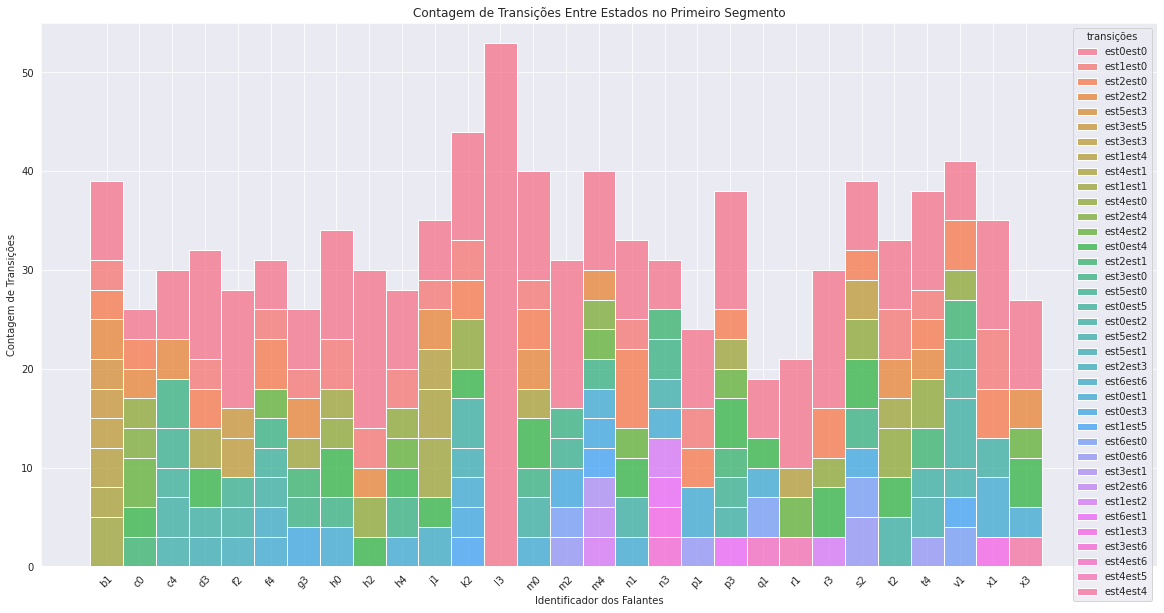

In [21]:
df_front = df_front.rename(columns = {"wd3": "transições"})#, "aut": "participantes"})
sns.histplot(x=df_front.aut, data=df_front, stat="count", multiple="stack", hue="transições", kde=False,).set(
    xlim=(-2,32),ylim=(0, 55),title="Contagem de Transições Entre Estados no Primeiro Segmento", xlabel="Identificador dos Falantes", ylabel="Contagem de Transições")
plt.xticks(rotation=45)
plt.gcf().set_size_inches(20, 10)

## Plotagem do Vocabulário Final dos Participantes
Conta quantas sílabas os participantes falaram na porção final do jogo

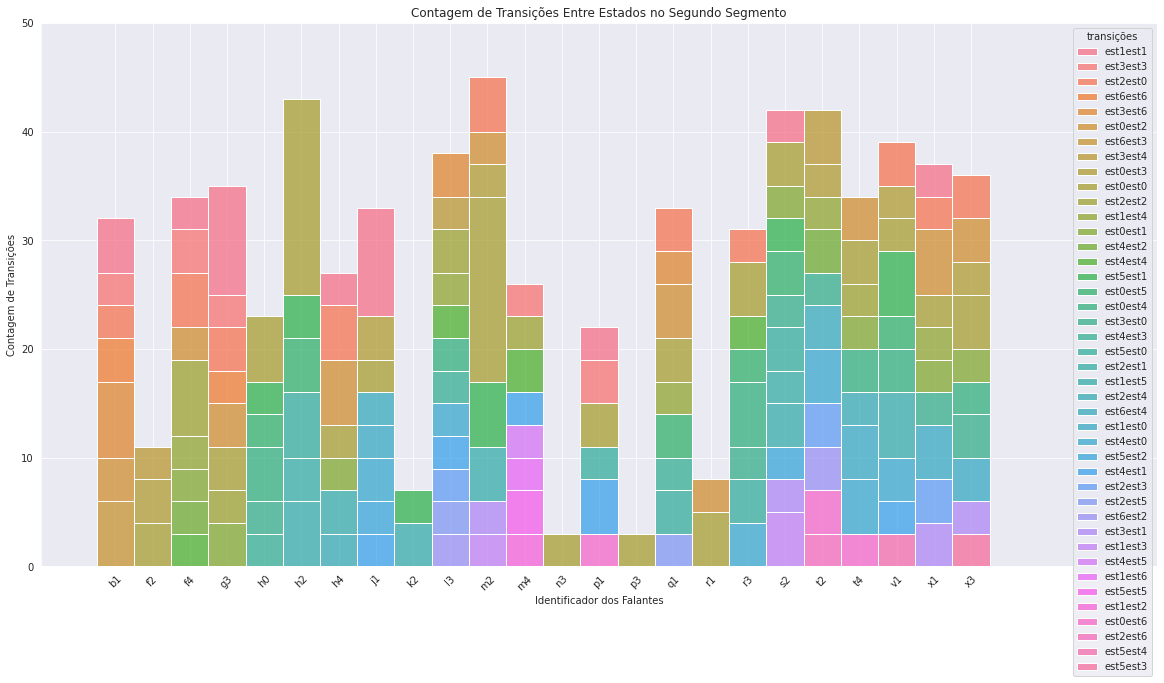

In [22]:
df_back = df_back.rename(columns = {"wd3": "transições"})#, "aut": "participantes"})
sns.histplot(x=df_back.aut, data=df_back, stat="count", multiple="stack", hue="transições", kde=False,).set(
    xlim=(-2,28),ylim=(0, 50),title="Contagem de Transições Entre Estados no Segundo Segmento", xlabel="Identificador dos Falantes", ylabel="Contagem de Transições")
plt.xticks(rotation=45)
plt.gcf().set_size_inches(20, 10)

## Plotagem do Vocabulário Final por Transições
Conta quantos participantes expressaram uma dada trasição na porção final do jogo


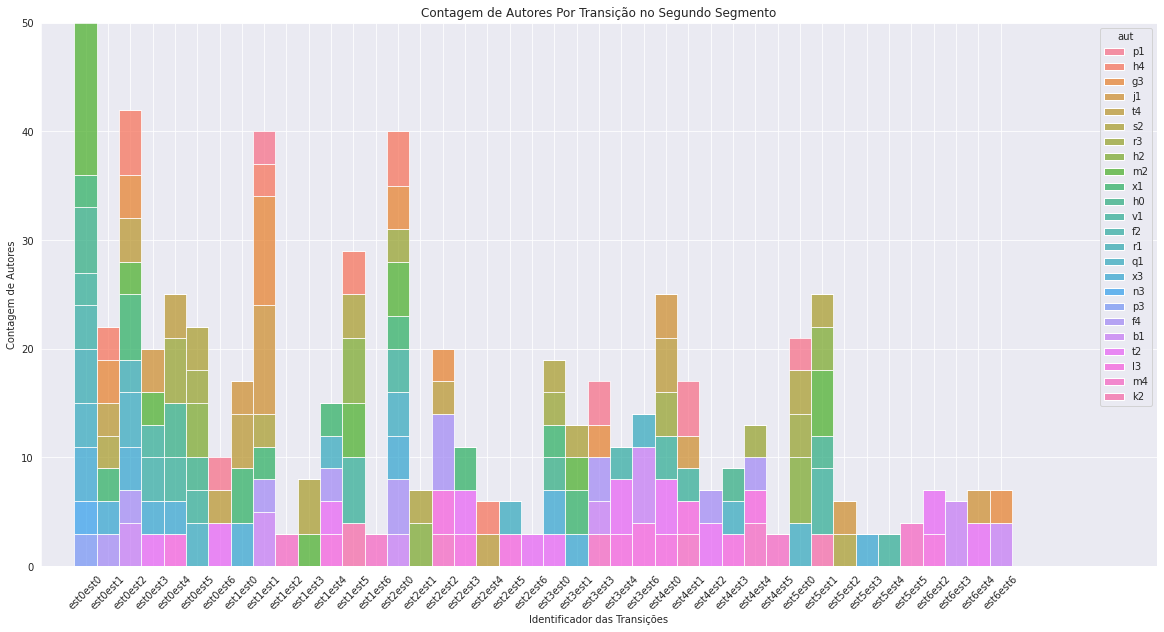

In [23]:
df_back_sort = df_back.sort_values(by="transições")

sns.histplot(x=df_back_sort.transições, data=df_back_sort, stat="count", multiple="stack", hue="aut", kde=False,).set(
    xlim=(-2,48),ylim=(0, 50),title="Contagem de Autores Por Transição no Segundo Segmento", xlabel="Identificador das Transições", ylabel="Contagem de Autores")
plt.xticks(rotation=45)
plt.gcf().set_size_inches(20, 10)

## Plotagem do Vocabulário Inicial por Transições
Conta quantos participantes expressaram uma dada trasição na porção inicial do jogo


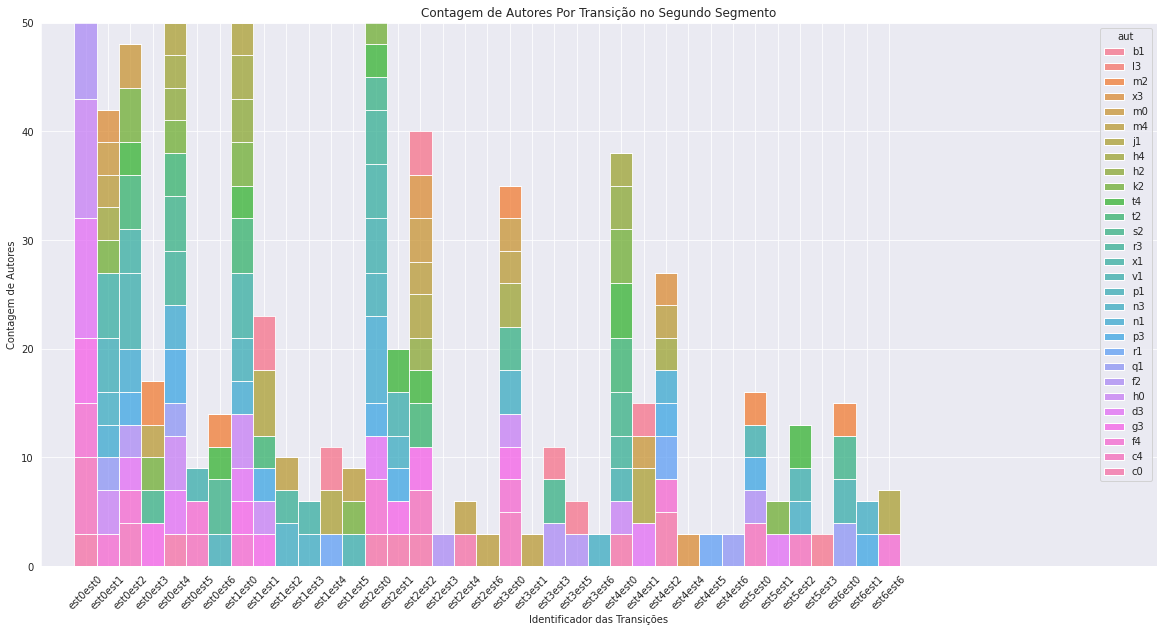

In [24]:
df_front_sort = df_front.sort_values(by="transições")

sns.histplot(x=df_front_sort.transições, data=df_front_sort, stat="count", multiple="stack", hue="aut", kde=False,).set(
    xlim=(-2,48),ylim=(0, 50),title="Contagem de Autores Por Transição no Segundo Segmento", xlabel="Identificador das Transições", ylabel="Contagem de Autores")
plt.xticks(rotation=45)
plt.gcf().set_size_inches(20, 10)

In [25]:
df_front = df_states[df_states['tempo'] <= 200]
df_back = df_states[(200 < df_states['tempo']) & ( df_states['tempo'] < 400)]
df_back

,aut,st,tempo,interval,stsum
67,b1,est1,201.264474,3.003947,128
68,b1,est1,204.268421,3.003947,128
69,b1,est4,207.272368,27.035526,128
70,b1,est1,210.276316,6.007895,128
71,b1,est1,213.280263,3.003947,128
...,...,...,...,...,...
3931,x3,est0,387.255109,3.001978,254
3932,x3,est0,390.257086,3.001978,254
3933,x3,est1,393.259064,33.021753,254
3934,x3,est0,396.261042,6.003955,254


## Calcula a metade frontal

/tmp/ipykernel_22790/869170020.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_front["stsumf"] = df_front.groupby("aut")["tempo"].transform('count')#.sum()


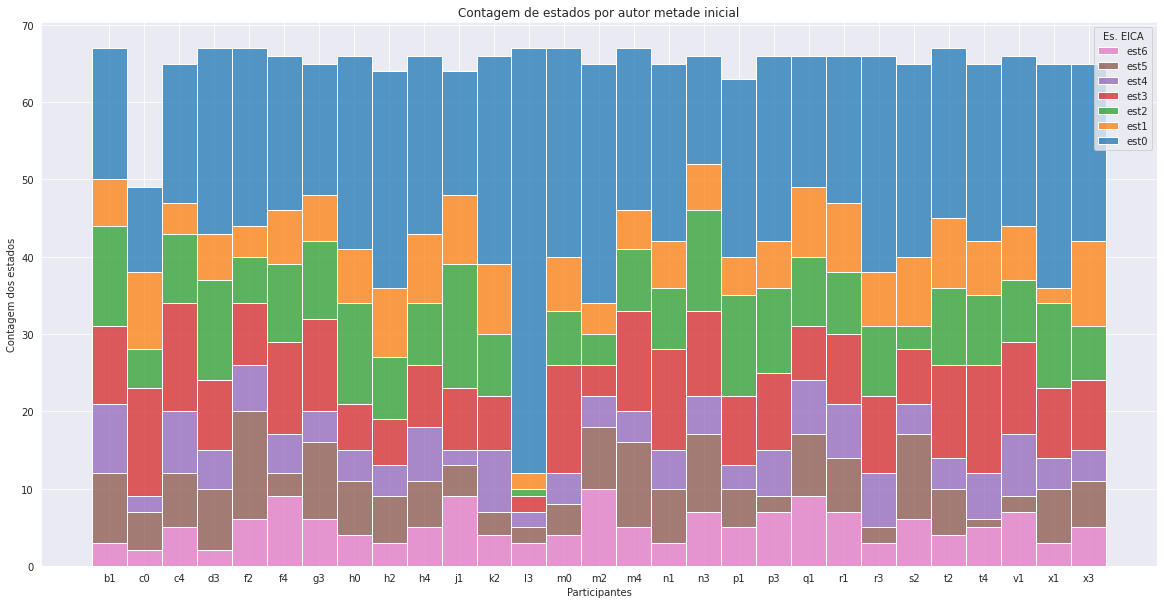

In [26]:
df_front["stsumf"] = df_front.groupby("aut")["tempo"].transform('count')#.sum()
d_sstf = df_front # df_front.sort_values(by="stsumf", ascending=False)
d_sstf = d_sstf.drop(["stsumf"], axis=1)

sns.histplot(x=d_sstf.aut, data=d_sstf, multiple="stack", hue=d_sstf.st).set(
    title="Contagem de estados por autor metade inicial", xlabel="Participantes", ylabel="Contagem dos estados")
plt.legend(title="Es. EICA", loc="upper right", labels=[f"est{s}" for s in range(6, -1, -1)])
plt.gcf().set_size_inches(20, 10)

## Calcula a metade final

/tmp/ipykernel_22790/3952249663.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_back["stsumb"] = df_back.groupby("aut")["tempo"].transform('count')#.sum()


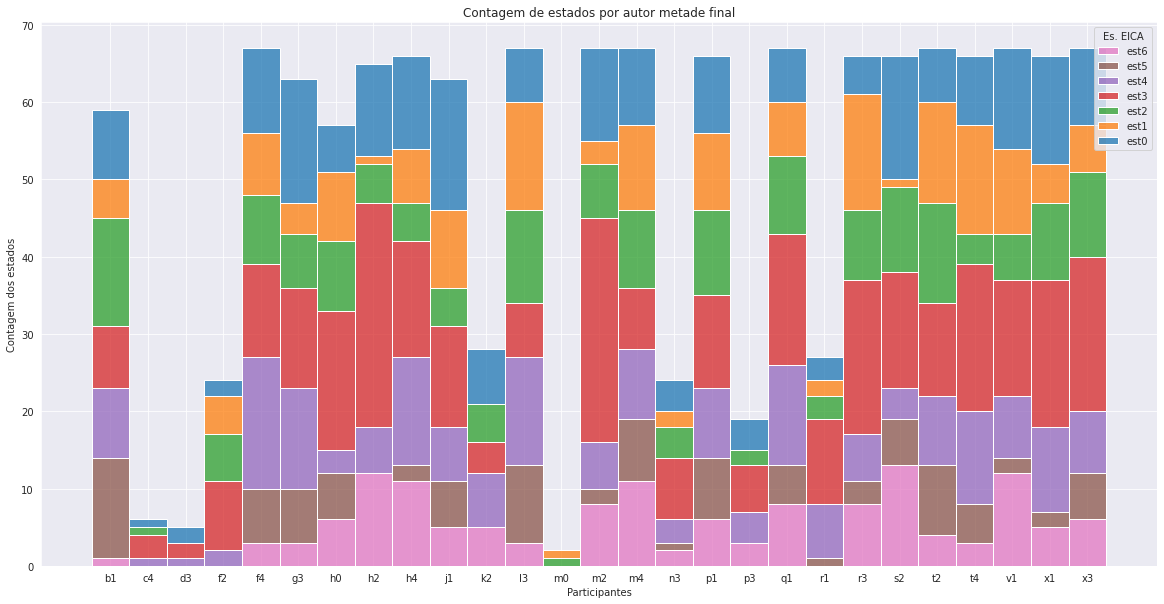

In [27]:
df_back["stsumb"] = df_back.groupby("aut")["tempo"].transform('count')#.sum()
d_sstb = df_back # df_back.sort_values(by="stsumb", ascending=False)
d_sstb = d_sstb.drop(["stsumb"], axis=1)

sns.histplot(x=d_sstb.aut, data=d_sstb, multiple="stack", hue=d_sstb.st).set(
    title="Contagem de estados por autor metade final", xlabel="Participantes", ylabel="Contagem dos estados")
plt.legend(title="Es. EICA", loc="upper right", labels=[f"est{s}" for s in range(6, -1, -1)])
plt.gcf().set_size_inches(20, 10)

## Contagem de palavras de duas letras

Concatenação de um estado com o estado seguinte para observar as sílabas do vocabulário mental

In [28]:
df_back["wd3"] = df_back.groupby("aut")["st"].transform(lambda st: st+st.shift(1)) #+st.shift(2))
df_back["wd3cnt"] = df_back.groupby(["aut", 'wd3'])["wd3"].transform("count")
df_back = df_back[df_back["wd3cnt"] >2]

df_front["wd3"] = df_front.groupby("aut")["st"].transform(lambda st: st+st.shift(1)) #+st.shift(2))
df_front["wd3cnt"] = df_front.groupby(["aut", 'wd3'])["wd3"].transform("count")
df_front = df_front[df_front["wd3cnt"] >2]
df_front

/tmp/ipykernel_22790/3357349702.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_back["wd3"] = df_back.groupby("aut")["st"].transform(lambda st: st+st.shift(1)) #+st.shift(2))
/tmp/ipykernel_22790/3357349702.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_back["wd3cnt"] = df_back.groupby(["aut", 'wd3'])["wd3"].transform("count")
/tmp/ipykernel_22790/3357349702.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

,aut,st,tempo,interval,stsum,stsumf,wd3,wd3cnt
1,b1,est0,3.003947,3.003947,128,67,est0est0,8.0
2,b1,est0,6.007895,3.003947,128,67,est0est0,8.0
3,b1,est0,9.011842,3.003947,128,67,est0est0,8.0
6,b1,est1,18.023684,NaN,128,67,est1est0,3.0
8,b1,est2,24.031579,NaN,128,67,est2est0,3.0
...,...,...,...,...,...,...,...,...
3856,x3,est4,162.106790,3.001978,254,67,est4est4,3.0
3861,x3,est4,177.116678,3.001978,254,67,est4est4,3.0
3864,x3,est0,186.122610,18.011866,254,67,est0est1,3.0
3867,x3,est0,195.128543,3.001978,254,67,est0est0,9.0


## Contagem das Transições Expressas por Participante
Conta quantas transições cada participante expressou em cada metade do jogo


In [29]:
s = df_front.groupby('wd3').agg({'aut': lambda x: tuple(sorted(set(x))), 'wd3cnt':'count'})
df_vocabulary = s.explode('aut').reset_index()
df_vocabulary["speak_token"] = df_vocabulary.groupby('aut')['wd3cnt'].transform('count')
df_vocabulary = df_vocabulary[df_vocabulary["speak_token"]>2]
df_vocabulary.head(5)
s = df_back.groupby('wd3').agg({'aut': lambda x: tuple(sorted(set(x))), 'wd3cnt':'count'})
df_end_vocabulary = s.explode('aut').reset_index()
df_end_vocabulary["speak_token"] = df_end_vocabulary.groupby('aut')['wd3cnt'].transform('count')
df_end_vocabulary = df_end_vocabulary[df_end_vocabulary["speak_token"]>2]
df_end_vocabulary.head(5)

,wd3,aut,wd3cnt,speak_token
0,est0est0,f2,98,3
1,est0est0,g3,98,8
2,est0est0,h0,98,6
3,est0est0,h2,98,6
4,est0est0,h4,98,7


## Plotagem do Vocabulário Inicial dos Participantes
Conta quantas sílabas os participantes falaram na porção inicial do jogo

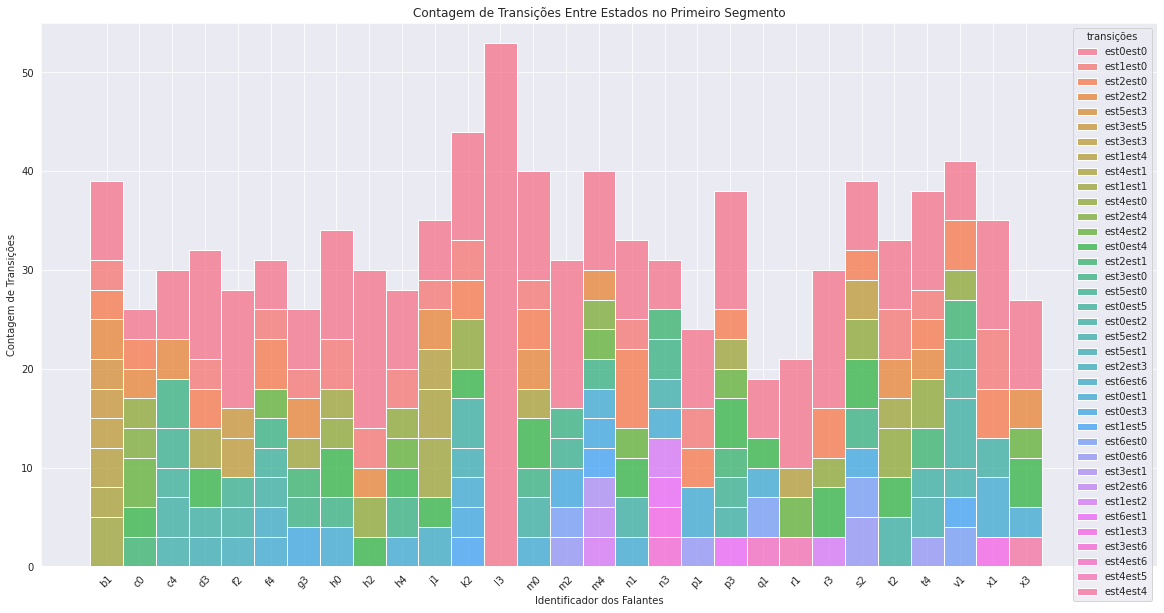

In [30]:
df_front = df_front.rename(columns = {"wd3": "transições"})#, "aut": "participantes"})
sns.histplot(x=df_front.aut, data=df_front, stat="count", multiple="stack", hue="transições", kde=False,).set(
    xlim=(-2,32),ylim=(0, 55),title="Contagem de Transições Entre Estados no Primeiro Segmento", xlabel="Identificador dos Falantes", ylabel="Contagem de Transições")
plt.xticks(rotation=45)
plt.gcf().set_size_inches(20, 10)

## Plotagem do Vocabulário Final dos Participantes
Conta quantas sílabas os participantes falaram na porção final do jogo

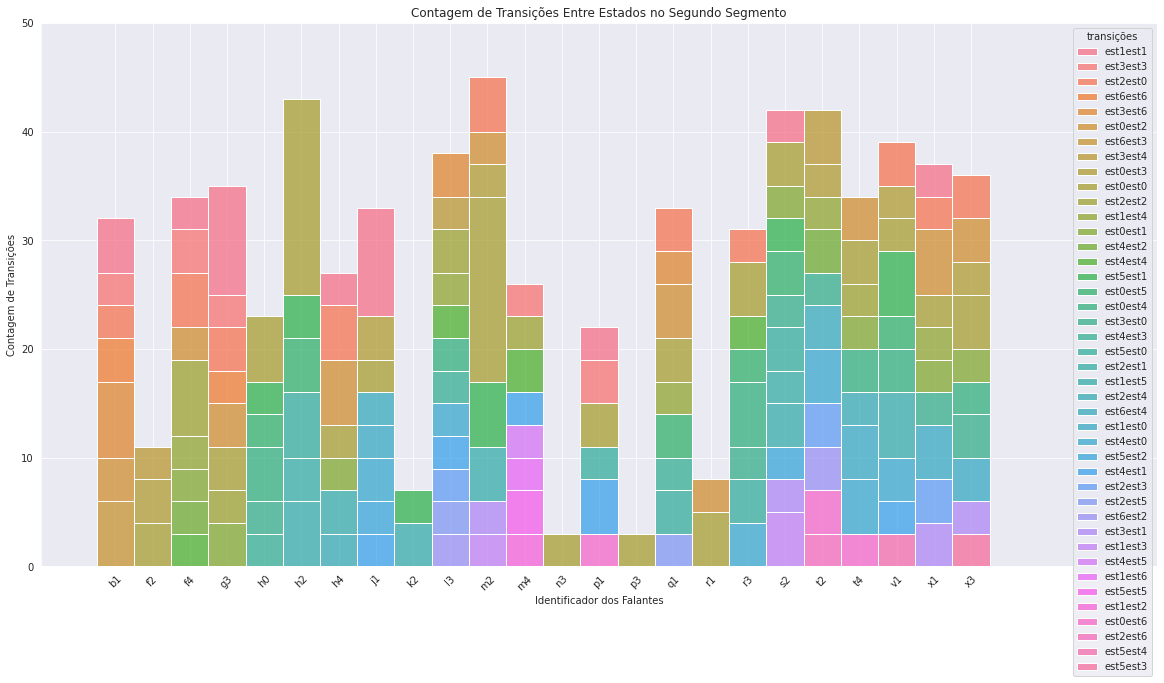

In [31]:
df_back = df_back.rename(columns = {"wd3": "transições"})#, "aut": "participantes"})
sns.histplot(x=df_back.aut, data=df_back, stat="count", multiple="stack", hue="transições", kde=False,).set(
    xlim=(-2,28),ylim=(0, 50),title="Contagem de Transições Entre Estados no Segundo Segmento", xlabel="Identificador dos Falantes", ylabel="Contagem de Transições")
plt.xticks(rotation=45)
plt.gcf().set_size_inches(20, 10)

## Plotagem do Vocabulário Final por Transições
Conta quantos participantes expressaram uma dada trasição na porção final do jogo


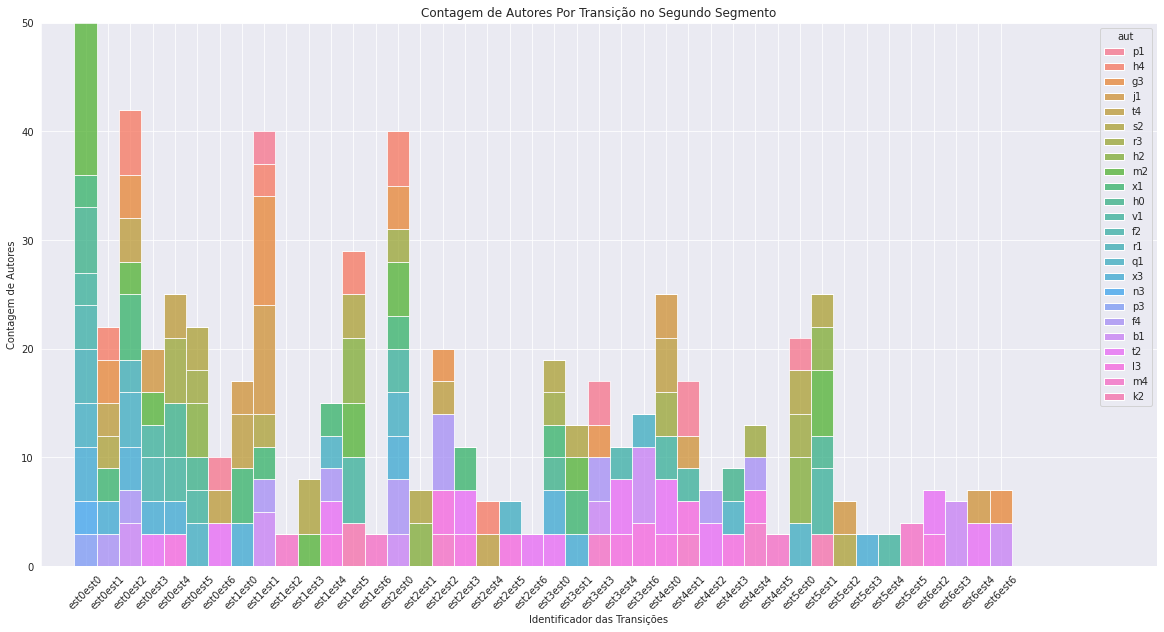

In [32]:
df_back_sort = df_back.sort_values(by="transições")

sns.histplot(x=df_back_sort.transições, data=df_back_sort, stat="count", multiple="stack", hue="aut", kde=False,).set(
    xlim=(-2,48),ylim=(0, 50),title="Contagem de Autores Por Transição no Segundo Segmento", xlabel="Identificador das Transições", ylabel="Contagem de Autores")
plt.xticks(rotation=45)
plt.gcf().set_size_inches(20, 10)

## Plotagem do Vocabulário Inicial por Transições
Conta quantos participantes expressaram uma dada trasição na porção inicial do jogo


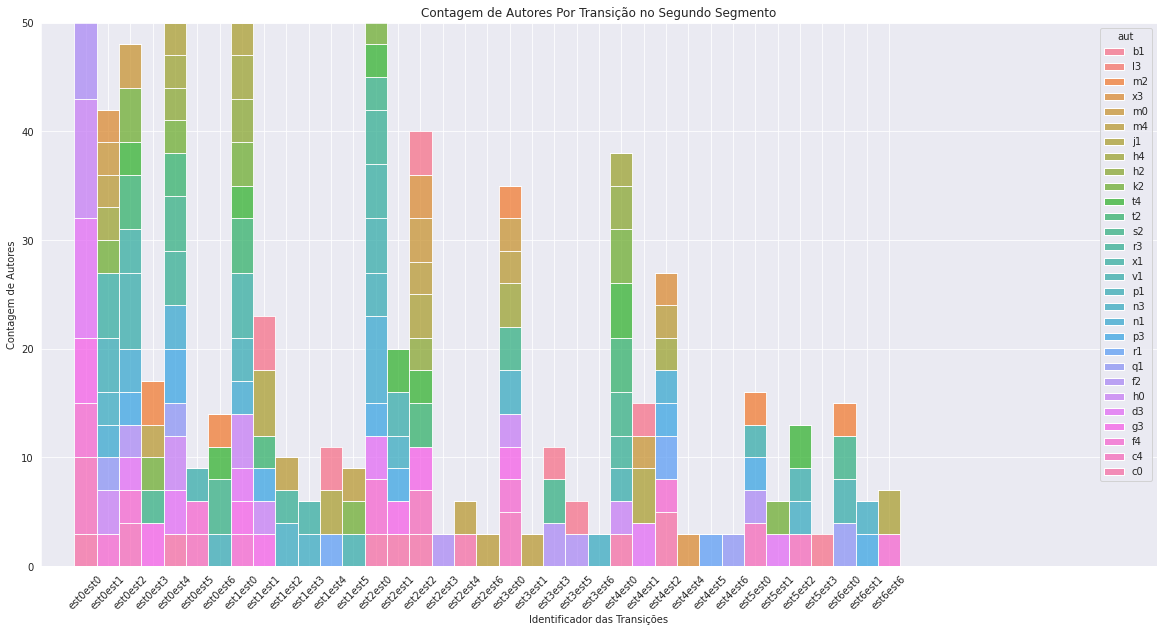

In [33]:
df_front_sort = df_front.sort_values(by="transições")

sns.histplot(x=df_front_sort.transições, data=df_front_sort, stat="count", multiple="stack", hue="aut", kde=False,).set(
    xlim=(-2,48),ylim=(0, 50),title="Contagem de Autores Por Transição no Segundo Segmento", xlabel="Identificador das Transições", ylabel="Contagem de Autores")
plt.xticks(rotation=45)
plt.gcf().set_size_inches(20, 10)

## Calcula a metade frontal

/tmp/ipykernel_41043/869170020.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_front["stsumf"] = df_front.groupby("aut")["tempo"].transform('count')#.sum()


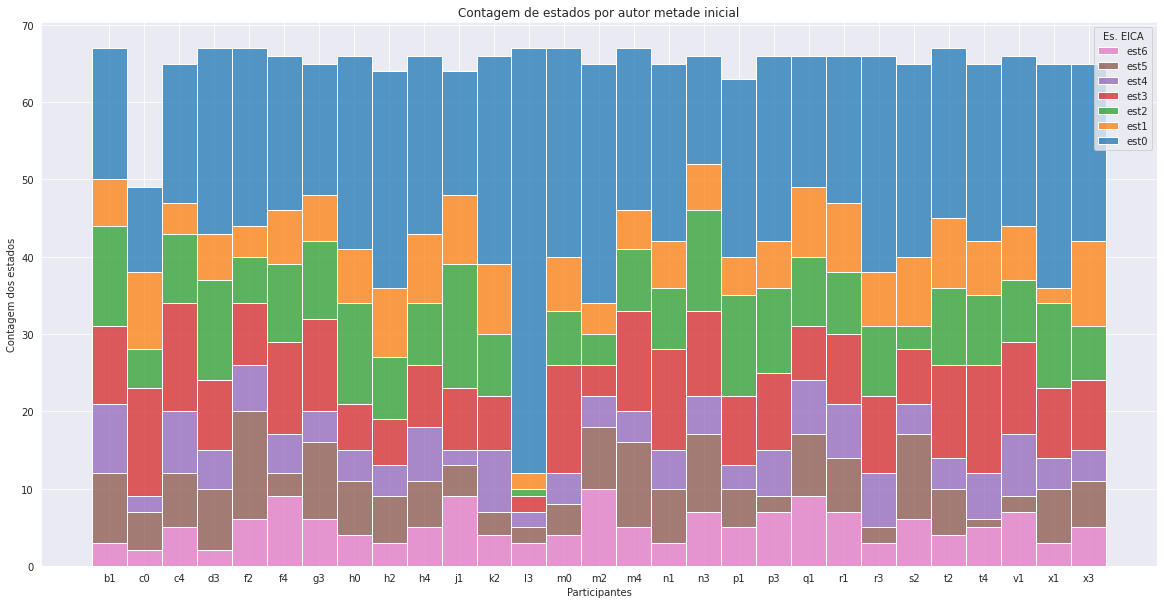

In [133]:
df_front["stsumf"] = df_front.groupby("aut")["tempo"].transform('count')#.sum()
d_sstf = df_front # df_front.sort_values(by="stsumf", ascending=False)
d_sstf = d_sstf.drop(["stsumf"], axis=1)

sns.histplot(x=d_sstf.aut, data=d_sstf, multiple="stack", hue=d_sstf.st).set(
    title="Contagem de estados por autor metade inicial", xlabel="Participantes", ylabel="Contagem dos estados")
plt.legend(title="Es. EICA", loc="upper right", labels=[f"est{s}" for s in range(6, -1, -1)])
plt.gcf().set_size_inches(20, 10)

## Calcula a metade final

/tmp/ipykernel_41043/3952249663.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_back["stsumb"] = df_back.groupby("aut")["tempo"].transform('count')#.sum()


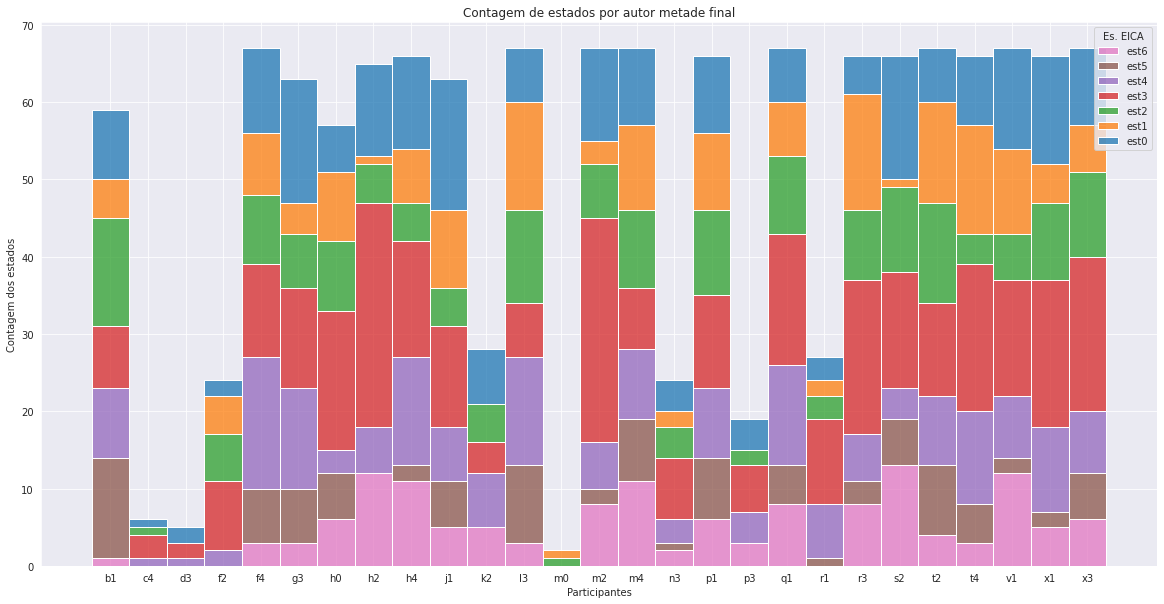

In [134]:
df_back["stsumb"] = df_back.groupby("aut")["tempo"].transform('count')#.sum()
d_sstb = df_back # df_back.sort_values(by="stsumb", ascending=False)
d_sstb = d_sstb.drop(["stsumb"], axis=1)

sns.histplot(x=d_sstb.aut, data=d_sstb, multiple="stack", hue=d_sstb.st).set(
    title="Contagem de estados por autor metade final", xlabel="Participantes", ylabel="Contagem dos estados")
plt.legend(title="Es. EICA", loc="upper right", labels=[f"est{s}" for s in range(6, -1, -1)])
plt.gcf().set_size_inches(20, 10)

## Contagem de palavras de duas letras

Concatenação de um estado com o estado seguinte para observar as sílabas do vocabulário mental

In [135]:
df_back["wd3"] = df_back.groupby("aut")["st"].transform(lambda st: st+st.shift(1)) #+st.shift(2))
df_back["wd3cnt"] = df_back.groupby(["aut", 'wd3'])["wd3"].transform("count")
df_back = df_back[df_back["wd3cnt"] >2]

df_front["wd3"] = df_front.groupby("aut")["st"].transform(lambda st: st+st.shift(1)) #+st.shift(2))
df_front["wd3cnt"] = df_front.groupby(["aut", 'wd3'])["wd3"].transform("count")
df_front = df_front[df_front["wd3cnt"] >2]
df_front

/tmp/ipykernel_41043/3357349702.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_back["wd3"] = df_back.groupby("aut")["st"].transform(lambda st: st+st.shift(1)) #+st.shift(2))
/tmp/ipykernel_41043/3357349702.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_back["wd3cnt"] = df_back.groupby(["aut", 'wd3'])["wd3"].transform("count")
/tmp/ipykernel_41043/3357349702.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

,aut,st,tempo,interval,stsum,stsumf,wd3,wd3cnt
1,b1,est0,3.003947,3.003947,128,67,est0est0,8.0
2,b1,est0,6.007895,3.003947,128,67,est0est0,8.0
3,b1,est0,9.011842,3.003947,128,67,est0est0,8.0
6,b1,est1,18.023684,NaN,128,67,est1est0,3.0
8,b1,est2,24.031579,NaN,128,67,est2est0,3.0
...,...,...,...,...,...,...,...,...
3856,x3,est4,162.106790,3.001978,254,67,est4est4,3.0
3861,x3,est4,177.116678,3.001978,254,67,est4est4,3.0
3864,x3,est0,186.122610,18.011866,254,67,est0est1,3.0
3867,x3,est0,195.128543,3.001978,254,67,est0est0,9.0


## Contagem das Transições Expressas por Participante
Conta quantas transições cada participante expressou em cada metade do jogo


In [136]:
s = df_front.groupby('wd3').agg({'aut': lambda x: tuple(sorted(set(x))), 'wd3cnt':'count'})
df_vocabulary = s.explode('aut').reset_index()
df_vocabulary["speak_token"] = df_vocabulary.groupby('aut')['wd3cnt'].transform('count')
df_vocabulary = df_vocabulary[df_vocabulary["speak_token"]>2]
df_vocabulary.head(5)
s = df_back.groupby('wd3').agg({'aut': lambda x: tuple(sorted(set(x))), 'wd3cnt':'count'})
df_end_vocabulary = s.explode('aut').reset_index()
df_end_vocabulary["speak_token"] = df_end_vocabulary.groupby('aut')['wd3cnt'].transform('count')
df_end_vocabulary = df_end_vocabulary[df_end_vocabulary["speak_token"]>2]
df_end_vocabulary.head(5)

,wd3,aut,wd3cnt,speak_token
0,est0est0,f2,98,3
1,est0est0,g3,98,8
2,est0est0,h0,98,6
3,est0est0,h2,98,6
4,est0est0,h4,98,7


## Plotagem do Vocabulário Inicial dos Participantes
Conta quantas sílabas os participantes falaram na porção inicial do jogo

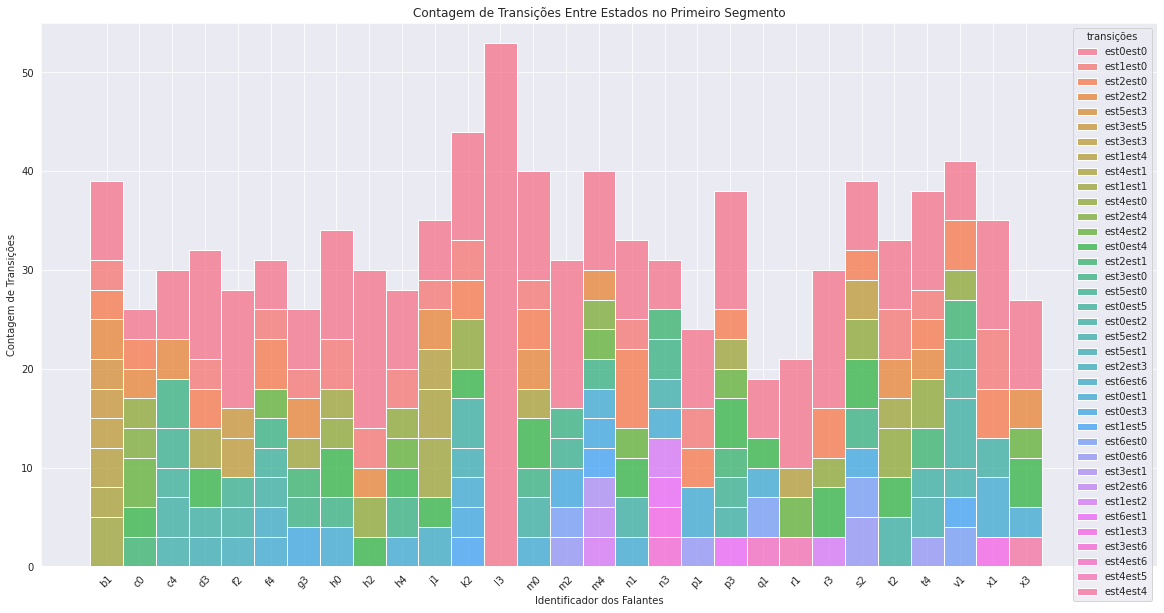

In [137]:
df_front = df_front.rename(columns = {"wd3": "transições"})#, "aut": "participantes"})
sns.histplot(x=df_front.aut, data=df_front, stat="count", multiple="stack", hue="transições", kde=False,).set(
    xlim=(-2,32),ylim=(0, 55),title="Contagem de Transições Entre Estados no Primeiro Segmento", xlabel="Identificador dos Falantes", ylabel="Contagem de Transições")
plt.xticks(rotation=45)
plt.gcf().set_size_inches(20, 10)

## Plotagem do Vocabulário Final dos Participantes
Conta quantas sílabas os participantes falaram na porção final do jogo

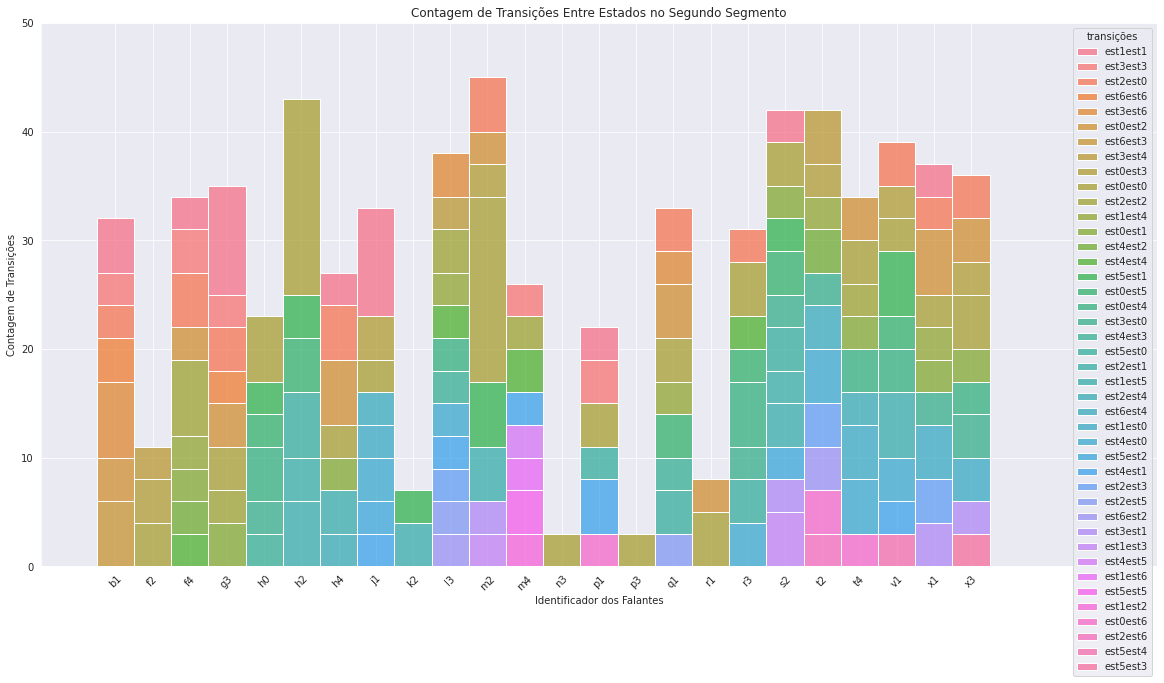

In [138]:
df_back = df_back.rename(columns = {"wd3": "transições"})#, "aut": "participantes"})
sns.histplot(x=df_back.aut, data=df_back, stat="count", multiple="stack", hue="transições", kde=False,).set(
    xlim=(-2,28),ylim=(0, 50),title="Contagem de Transições Entre Estados no Segundo Segmento", xlabel="Identificador dos Falantes", ylabel="Contagem de Transições")
plt.xticks(rotation=45)
plt.gcf().set_size_inches(20, 10)

## Plotagem do Vocabulário Final por Transições
Conta quantos participantes expressaram uma dada trasição na porção final do jogo


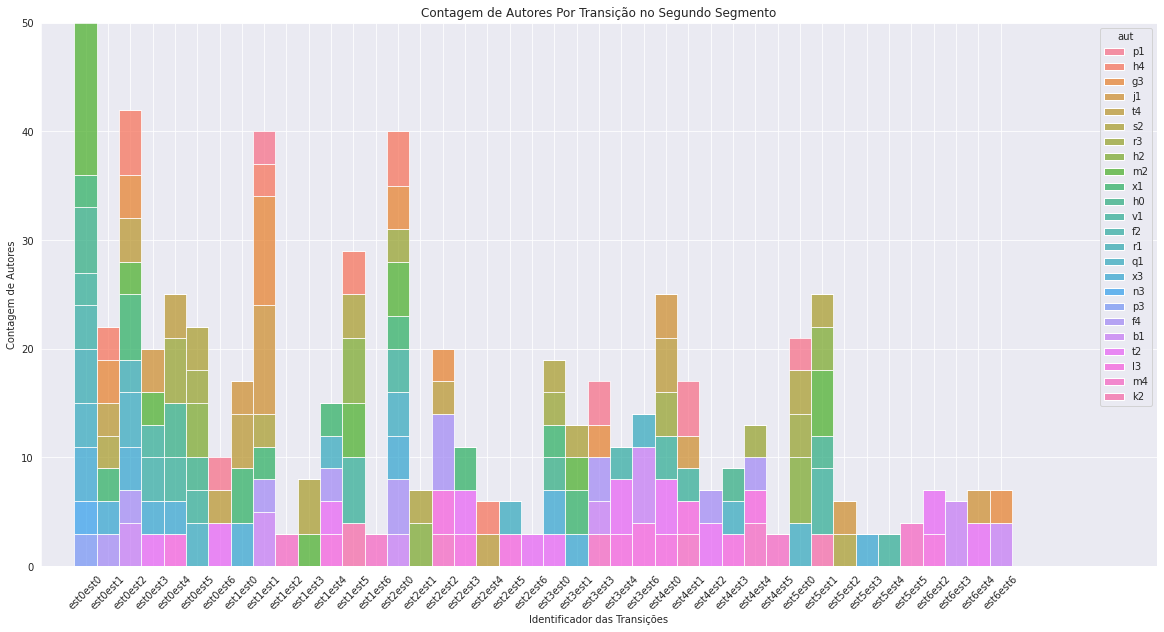

In [143]:
df_back_sort = df_back.sort_values(by="transições")

sns.histplot(x=df_back_sort.transições, data=df_back_sort, stat="count", multiple="stack", hue="aut", kde=False,).set(
    xlim=(-2,48),ylim=(0, 50),title="Contagem de Autores Por Transição no Segundo Segmento", xlabel="Identificador das Transições", ylabel="Contagem de Autores")
plt.xticks(rotation=45)
plt.gcf().set_size_inches(20, 10)

## Plotagem do Vocabulário Inicial por Transições
Conta quantos participantes expressaram uma dada trasição na porção inicial do jogo


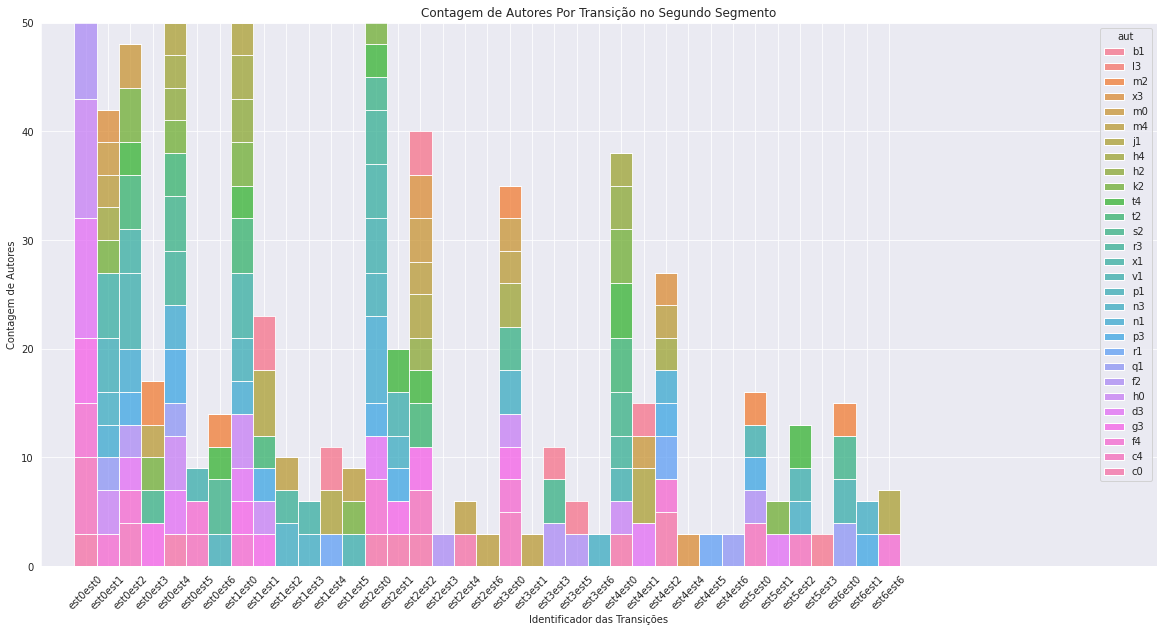

In [142]:
df_front_sort = df_front.sort_values(by="transições")

sns.histplot(x=df_front_sort.transições, data=df_front_sort, stat="count", multiple="stack", hue="aut", kde=False,).set(
    xlim=(-2,48),ylim=(0, 50),title="Contagem de Autores Por Transição no Segundo Segmento", xlabel="Identificador das Transições", ylabel="Contagem de Autores")
plt.xticks(rotation=45)
plt.gcf().set_size_inches(20, 10)